# Previsão de Fraudes de Cartão de Crédito

Dataset: https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset

## Setup

### Pacotes:

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
#from imblearn.over_sampling import SMOTE
from sklearn import metrics

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

seed = 1

plt.rcParams['figure.figsize'] = (3, 3)

ModuleNotFoundError: No module named 'scipy'

### Funções customisadas:

Anáise de variáveis categóricas:

In [2]:
def explore_cat(column_name, df, dict):
    df[column_name].value_counts().plot(kind = 'barh')

    prop = round(df_clean[column_name].value_counts() / len(df_clean) * 100, 1)
    print({dict[column_name][i]: f'{p}%' for i, p in zip(prop.index, prop)})

Análise de variáveis contínuas:

In [3]:
def explore_cont(column_names, df, nbins, log = False):
    fig = plt.figure()
    for i, name in enumerate(column_names):
        ax = fig.add_subplot(2, 3, i+1)
        df[name].hist(bins = nbins, ax = ax)
        ax.set_title(name)
        if log: plt.yscale('log')
    fig.tight_layout()
    plt.show()

Boxplots entre Y e variáveis contínuas:

In [4]:
def plot_boxplots(column_names, df, log = False, **kwargs):
    fig = plt.figure()
    for i, var_name in enumerate(column_names):
        ax = fig.add_subplot(2, 3, i+1)
        df.plot.box(column = var_name, by = 'default', ax = ax, **kwargs)
        ax.set_title(var_name)
        if log: plt.yscale('log')
    fig.tight_layout()
    plt.show()

Violinplots entre Y e variáveis contínuas:

In [5]:
def plot_violins(column_names, df, log = False, treshold = (-1000, 7500), **kwargs):
    df = df[(df_clean[column_names] >= treshold[0]).all(1) & (df_clean[column_names] <= treshold[1]).all(1)]
    fig = plt.figure()
    for i, var_name in enumerate(column_names):
        ax = fig.add_subplot(2, 3, i+1)
        ax.violinplot([df.loc[df.default == 1, var_name], df.loc[df.default == 0, var_name]],  **kwargs)
        ax.set_title(var_name)
        if log: plt.xscale('log')
    fig.tight_layout()
    plt.show()

Função customizadas para balanceamento de dataset:

In [6]:
def custom_resample(cond, replace, n, df):
    return resample(df.loc[df['default'] == cond],
                    replace = replace,
                    n_samples = n,
                    random_state = seed)

def balance_k(k, df): #0 for downsampling, 1 for upsampling, or something in between
    counts = df['default'].value_counts()
    n = round(counts[1] + k*(counts[0] - counts[1]))
    
    df_train_yes = custom_resample(1, True, n, df = df)
    df_train_no = custom_resample(0, False, n, df = df)

    df_train_balanced = pd.concat([df_train_yes, df_train_no])
    X_train = df_train_balanced.loc[:, df_train_balanced.columns != 'default']
    y_train = df_train_balanced['default']

    return (X_train, y_train)

def balance_smote():
    pass

Resultados de modelos:

In [7]:
def custom_metrics(model, X_test, y_test, scorings = ['TPR', 'TNR', 'Accuracy', 'Balanced accuracy', 'F1', 'K-fold'], kfold_n = 5, kfold_scoring = 'accuracy'):
  prediction = model.predict(X_test)
  confusion_matrix = metrics.confusion_matrix(y_test, prediction)

  metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot()
  plt.show()

  TN, FP, FN, TP = confusion_matrix.ravel()
  rates = {'TPR': TP / (TP + FN), 'TNR': TN / (TN + FP), 'PPV': TP / (TP + FP), 'NPV': TN / (TN + FN), 'Accuracy': (TP + TN) / (TP + FP + TN + FN)}
  rates.update({'Balanced accuracy': (rates['TPR'] + rates['TNR']) / 2,
                'F1 score': (2*TP) / (2*TP + FP + FN),
                'AUC': metrics.auc([0, 1 - rates['TNR'], 1], [0, rates['TPR'], 1])})

  for key, value in rates.items():
    if key in scorings: print(f'{key}: {round(value*100, 2)}%')
  
  #K-fold
  if 'K-fold' in scorings:
    scores = cross_val_score(model, X_test, y_test, cv = kfold_n, scoring = kfold_scoring)
    print('K-fold: %0.3f accuracy with a standard deviation of %0.3f' % (scores.mean(), scores.std()))

  #AUC
  if 'AUC' in scorings:
    plt.plot([0, 1 - rates['TNR'], 1], [0, rates['TPR'], 1], 'b-', label='ROC curve (AUC = %0.2f)' % rates['AUC'])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.show()

### Dados:

In [1]:
df_raw = pd.read_excel('default_of_credit_card_clients.xls')
display(df_raw)

NameError: name 'pd' is not defined

In [8]:
df_raw["EDUCATION"].value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

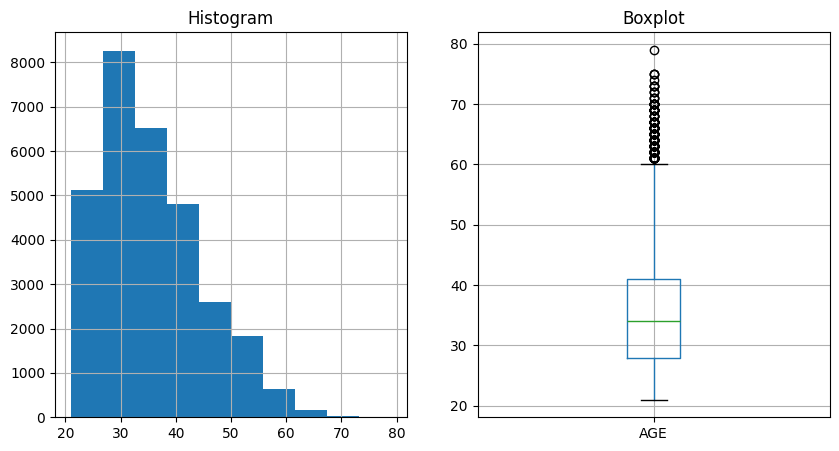

In [16]:
import matplotlib.pyplot as plt

def explore_cont(column_names, df):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    df[column_names].hist(ax=axes[0])
    axes[0].set_title('Histogram')

    df.boxplot(column=column_names, ax=axes[1])
    axes[1].set_title('Boxplot')

    plt.show()


explore_cont("AGE", df_raw)

In [ ]:
def explore_cat(column_name, df):
    df[column_name].value_counts().plot(kind = 'barh')
    prop = round(df[column_name].value_counts() / len(df) * 100, 1)
    print({df[column_name][i]: f'{p}%' for i, p in zip(prop.index, prop)})

In [ ]:
def plot_boxplots(column_names, df, log = False, **kwargs):
    fig = plt.figure()
    for i, var_name in enumerate(column_names):
        ax = fig.add_subplot(2, 3, i+1)
        df.plot.box(column = var_name, by = 'default', ax = ax, **kwargs)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

Renomear PAY_0 para PAY_1, remover a coluna ID, e transformar default para interger:

In [9]:
df_raw = df_raw.rename({'PAY_0': 'PAY_1', 'default payment next month': 'default'}, axis = 1)
df_raw = df_raw.drop('ID', axis = 1)
#df_raw['default'] = df_raw['default'].astype('int')

Dicionário e nomes de variáveis agrupadas:

In [10]:
dict_cat = {'SEX': {1: 'male', 2: 'female'},
            'EDUCATION': {0: 'unknown', 1: 'graduate school', 2: 'university', 3: 'high school', 4: 'others', 5: 'unknown', 6: 'unknown'},
            'MARRIAGE': {0: 'unknown', 1: 'married', 2: 'single', 3: 'others'},
            'default': {0: 'no', 1: 'yes'}}

names_status = [f'PAY_{i}' for i in range(1,7)]
names_pay = [f'PAY_AMT{i}' for i in range(1,7)]
names_bill = [f'BILL_AMT{i}' for i in range(1,7)]

A partir de agora, iremos trabalhar em um novo dataset:

In [11]:
df_clean = df_raw.copy()

In [ ]:
def plot_boxplot(column_name, df):
    df.plot.box(column = column_name, by = "acesso")

## Exploração e limpeza dos dados

Nesta seção iremos analisar as variáveis _in-natura_, procurando por algum erro de formatação, ou algum fato importante em suas distribuições

### Valores NA e tipo das variáveis:

In [12]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

### Variáveis categóricas

**Default:**

{'no': '77.9%', 'yes': '22.1%'}


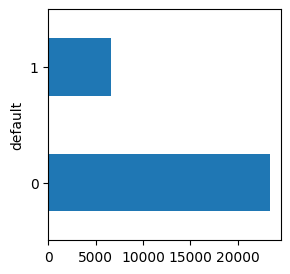

In [13]:
explore_cat('default', df = df_clean, dict = dict_cat)

**Sexo:**

{'female': '60.4%', 'male': '39.6%'}


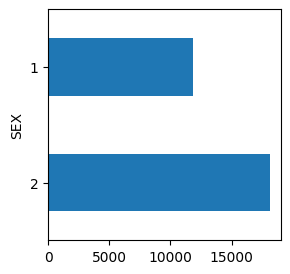

In [14]:
explore_cat('SEX', df = df_clean, dict = dict_cat)

**Educação:**

{'university': '46.8%', 'graduate school': '35.3%', 'high school': '16.4%', 'unknown': '0.0%', 'others': '0.4%'}


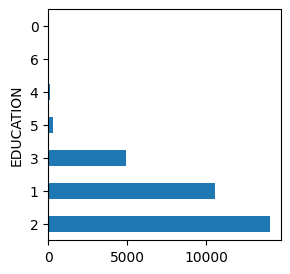

In [15]:
explore_cat('EDUCATION', df = df_clean, dict = dict_cat)

Os dados não documentados (0, 5, e 6) são em pequena quantidade, logo deve ser benéfico para o modelo uní-los na opção 'others'. Obs: todas as alterações serão feitas ao final desta seção

**Casamento:**

{'single': '53.2%', 'married': '45.5%', 'others': '1.1%', 'unknown': '0.2%'}


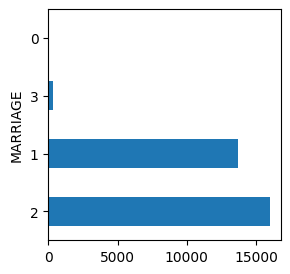

In [16]:
explore_cat('MARRIAGE', df = df_clean, dict = dict_cat)

Similarmente, o valor não documentado (0) será unido à 'others' 

### Variáveis numéricas

**Quantidade paga:**

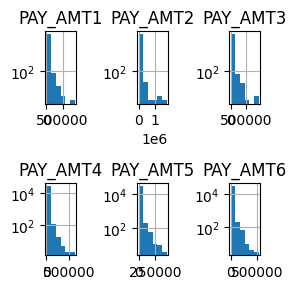

In [17]:
explore_cont(names_pay, df = df_clean, nbins = 6, log = True)

Como está em log, vemos que existe muitos valores próximos do 0. Isso pode ter a ver o fato de que a maioria das pessoas não deixam atrasar as contas, logo não precisam fazer esses pagamentos

**Quantidade de dívida:**

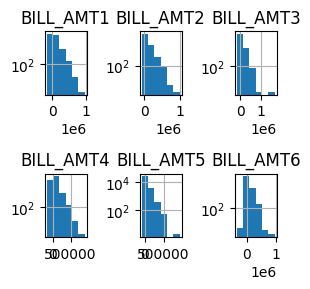

In [18]:
explore_cont(names_bill, df = df_clean, nbins = 6, log = True)

Vemos que realmente a quantidade de 0 nas contas atrasadas é muito grande, concordando com a análise anterior. Adicionalmente, vemos alguns valores negativos, que indicam crédito para aqueles que pagaram uma conta maior que o necessário

**Status do pagamento:**

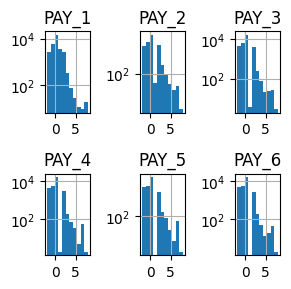

In [19]:
explore_cont(names_status, df = df_clean, nbins = 11, log = True)

Vemos a grande quantidade de valores -2, indicando pessoas que não haviam o que pagar, novamente confirmando a teoria supracitada. Iremos trocar o valor -1 'pago corretamente' para 0, e criar uma dummy para os casos -2 'não havia o que pagar'

**Limite:**

<Axes: ylabel='Frequency'>

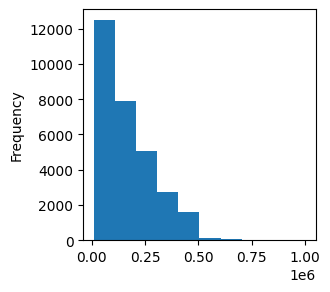

In [20]:
df_clean['LIMIT_BAL'].plot(kind = 'hist')

**Idade:**

<Axes: ylabel='Frequency'>

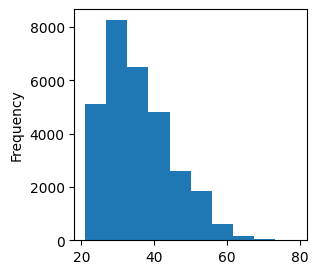

In [21]:
df_clean['AGE'].plot(kind = 'hist')

Os valores são esperados. Não parece haver grandes problemas de outliers

### Alterações

In [22]:
df_clean.loc[(df_clean.EDUCATION == 5) | (df_clean.EDUCATION == 6) | (df_clean.EDUCATION == 0), 'EDUCATION'] = 4
df_clean.loc[df_clean.MARRIAGE == 0, 'MARRIAGE'] = 3

for i in range(1,7):
    name = f'PAY_{i}'
    df_clean.loc[(df_clean[name] == -1) | (df_clean[name] == 0), name] = 0
    df_clean[f'NO_BILL_{i}'] = (df_clean[name] == -2).astype('int')
    dict_cat[f'NO_BILL_{i}'] = {0: 'positive bill', 1: 'null bill'}

## Análise exploratória

Nesta seção iremos buscar por relações simples entre as variáveis, dependentes e independentes, com o objetivo de gerar insumos para a modelagem

### Relações simples entre Y e x's

**Gráficos de correlação:**

Variáveis catergóricas e PAY_i:

In [23]:
for varname in list(dict_cat.keys()) + names_status:
    tab = pd.crosstab(index = df_clean['default'], columns = df_clean[varname])
    tab_norm = pd.crosstab(index = df_clean['default'], columns = df_clean[varname], normalize = 'columns').applymap(lambda x: f'{round(x*100, 1)}%')
    print(tab_norm, '\n', f'Cramer V coefficient: {round(stats.contingency.association(tab), 3)}', '\n')

SEX          1      2
default              
0        75.8%  79.2%
1        24.2%  20.8% 
 Cramer V coefficient: 0.04 

EDUCATION      1      2      3      4
default                              
0          80.8%  76.3%  74.8%  92.9%
1          19.2%  23.7%  25.2%   7.1% 
 Cramer V coefficient: 0.073 

MARRIAGE      1      2      3
default                      
0         76.5%  79.1%  76.4%
1         23.5%  20.9%  23.6% 
 Cramer V coefficient: 0.031 

default       0       1
default                
0        100.0%    0.0%
1          0.0%  100.0% 
 Cramer V coefficient: 1.0 

NO_BILL_1      0      1
default                
0          77.0%  86.8%
1          23.0%  13.2% 
 Cramer V coefficient: 0.068 

NO_BILL_2      0      1
default                
0          77.3%  81.7%
1          22.7%  18.3% 
 Cramer V coefficient: 0.035 

NO_BILL_3      0      1
default                
0          77.3%  81.5%
1          22.7%  18.5% 
 Cramer V coefficient: 0.034 

NO_BILL_4      0      1
default    

Variáveis contínuas (ignorando PAY_i = -2):

In [24]:
temp = df_clean.drop(list(dict_cat.keys()), axis = 1)
temp[names_status] = temp[names_status].replace(-2, np.NaN)

#print(round(temp.corr(method='pearson')['default'], 4))
round(temp.corrwith(df_clean['default'], method=stats.pointbiserialr), 4)

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.1535,0.0139,0.4038,0.3451,0.304,0.2873,0.2801,0.2647,-0.0196,-0.0142,-0.0141,-0.0102,-0.0068,-0.0054,-0.0729,-0.0586,-0.0563,-0.0568,-0.0551,-0.0532
1,0.0000,0.0161,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0007,0.0140,0.0148,0.0786,0.2416,0.3521,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


**Quantidade paga:**

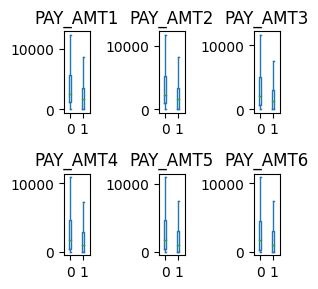

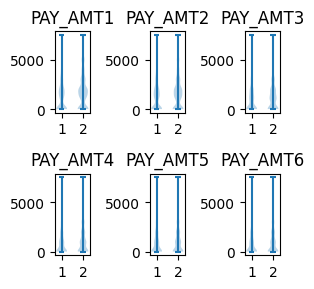

In [25]:
plot_boxplots(names_pay, df = df_clean, showfliers = False)
plot_violins(names_pay, df = df_clean)

A relação bimodal, mais clara nos três primeiros gráficos, pode motivar a inlcusão de efeitos não lineares nessas variáveis. Além disso, vemos que as distribuições condicionais não diferem tanto para as três últimas, possivelmente sendo features menos importantes

**Quantidade de dívida:**

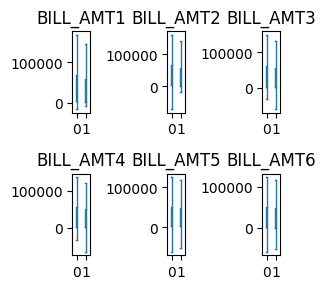

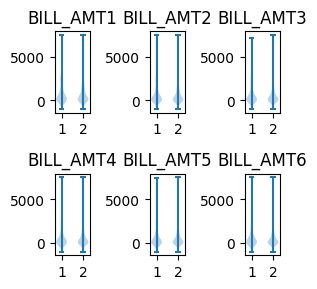

In [26]:
plot_boxplots(names_bill, df = df_clean, showfliers = False)
plot_violins(names_bill, df = df_clean)

Vemos que a quantidade de dívida e quantidade paga tem muita pouca correlação com o default. Talvez seja útil criar uma variável que seja a diferença entre elas

**Status do pagamento:**

In [27]:
#plot_boxplots(names_status, df = df_clean, showfliers = False)
#plot_violins(names_status, df = df_clean)

**Limite:**

{'bodies': [<matplotlib.collections.PolyCollection at 0x20670d27250>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x20670fea790>,
 'cmins': <matplotlib.collections.LineCollection at 0x206726330d0>,
 'cbars': <matplotlib.collections.LineCollection at 0x20672633690>}

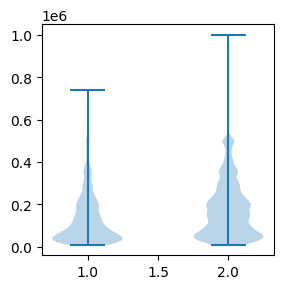

In [28]:
plt.violinplot([df_clean.loc[df_clean.default == 1, 'LIMIT_BAL'], df_clean.loc[df_clean.default == 0, 'LIMIT_BAL']])

**Idade:**

{'bodies': [<matplotlib.collections.PolyCollection at 0x20670c81150>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x20670c352d0>,
 'cmins': <matplotlib.collections.LineCollection at 0x20670c28790>,
 'cbars': <matplotlib.collections.LineCollection at 0x20670fa2c50>}

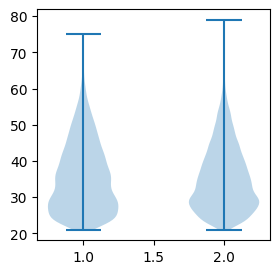

In [29]:
plt.violinplot([df_clean.loc[df_clean.default == 1, 'AGE'], df_clean.loc[df_clean.default == 0, 'AGE']])

Em vários casos incluir idade ao quadrado pode ser interessante, mas as distribuições condicionais não são tão diferentes

### Relações entre X's

...

### Alterações

Criando as variáveis 'net':

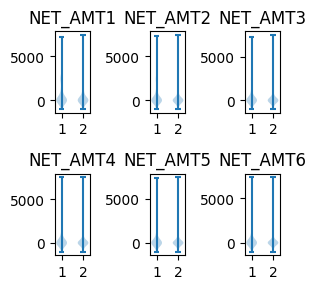

,NET_AMT1,NET_AMT2,NET_AMT3,NET_AMT4,NET_AMT5,NET_AMT6
0,-0.0033,0.0047,0.0002,0.0037,0.0071,0.0104
1,0.5723,0.4177,0.9715,0.5228,0.2175,0.0717


In [30]:
for i in range(1,7):
    df_clean[f'NET_AMT{i}'] = df_clean[f'BILL_AMT{i}'] - df_clean[f'PAY_AMT{i}']

names_net = [f'NET_AMT{i}' for i in range(1,7)]
plot_violins(names_net, df = df_clean)
round(df_clean[names_net].corrwith(df_clean['default'], method=stats.pointbiserialr), 4)


Parece ter uma relação ligeiramente melhor.

Criando o quadrado das variáveis de pay:

In [31]:
for i in range(1,7):
    df_clean[f'PAY_{i}_SQRD'] = df_clean[f'PAY_{i}']^2

df_clean['AGE_SQRD'] = df_clean['AGE']^2

names_squared = [f'PAY_{i}_SQRD' for i in range(1,7)]

## Modelagem

### Setup

Selecionando as features:

In [32]:
#all names: names_bill + names_net + names_pay + names_status + names_squared + list(dict_cat.keys()) + ['AGE', 'AGE_SQRD', 'LIMIT_BAL']
df_model = df_clean[names_net + names_status + ['SEX', 'EDUCATION', 'MARRIAGE', 'default'] + ['AGE', 'LIMIT_BAL']]

Separando o dataset em treino e teste:

In [33]:
df_train, df_check = train_test_split(df_model, test_size = 0.2, random_state = seed)

X_test = df_check.loc[:, df_check.columns != 'default']
y_test = df_check['default']

X_train, y_train = balance_k(0, df = df_train)

Definindo o _scoring_ para o GridSearch:

In [34]:
#Options: https://scikit-learn.org/stable/modules/model_evaluation.html. 'accuracy', 'balanced_accuracy', 'f1', 'roc_auc'
scoring = 'balanced_accuracy'

### Regressão Logística

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

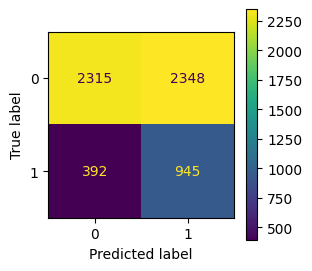

TPR: 70.68%
TNR: 49.65%
Accuracy: 54.33%
Balanced accuracy: 60.16%
K-fold: 0.777 accuracy with a standard deviation of 0.000


In [35]:
mod_logi = LogisticRegression(solver = 'lbfgs', penalty = None, random_state = seed).fit(X_train, y_train)
custom_metrics(mod_logi, X_test, y_test)

{'penalty': 'l1', 'solver': 'liblinear'}
0.6949394230940544


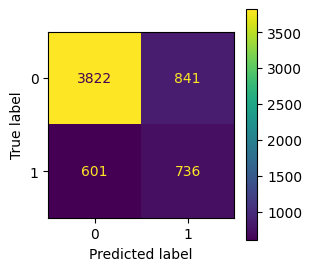

TPR: 55.05%
TNR: 81.96%
Accuracy: 75.97%
Balanced accuracy: 68.51%
K-fold: 0.813 accuracy with a standard deviation of 0.008


In [36]:
param_dist = [
    {'solver': ['lbfgs'],
     'penalty': [None, 'l2']},
    {'solver': ['liblinear'],
     'penalty': ['l1', 'l2']}
]
#{'solver': ['saga'],
# 'penalty': ['elasticnet'],
# 'l1_ratio': [0, 0.5, 1]}

mod_logi_grid = GridSearchCV(LogisticRegression(random_state = seed), param_grid = param_dist, scoring = scoring).fit(X_train, y_train)

print(mod_logi_grid.best_params_)
print(mod_logi_grid.best_score_)
custom_metrics(mod_logi_grid, X_test, y_test)

### KNN

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

c:\Users\ricsc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


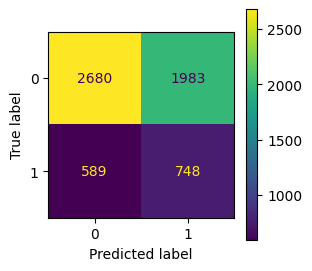

TPR: 55.95%
TNR: 57.47%
Accuracy: 57.13%
Balanced accuracy: 56.71%
K-fold: 0.746 accuracy with a standard deviation of 0.011


In [39]:
mod_knc = KNeighborsClassifier().fit(X_train, y_train)
custom_metrics(mod_knc, np.array(X_test), y_test)

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'distance'}


c:\Users\ricsc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


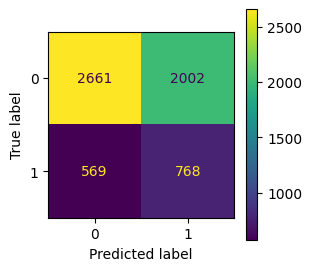

TPR: 57.44%
TNR: 57.07%
Accuracy: 57.15%
Balanced accuracy: 57.25%
K-fold: 0.745 accuracy with a standard deviation of 0.012


In [40]:
param_dist = {'n_neighbors': [5, 10, 50],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree']}

mod_knc_grid = GridSearchCV(KNeighborsClassifier(), param_grid = param_dist, scoring = scoring).fit(X_train, y_train)

print(mod_knc_grid.best_params_)
custom_metrics(mod_knc_grid, np.array(X_test), y_test)

### Decision Tree

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

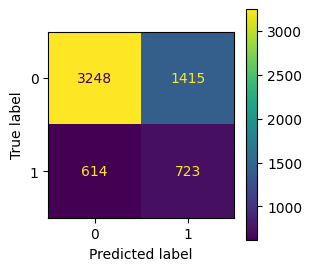

TPR: 54.08%
TNR: 69.65%
Accuracy: 66.18%
Balanced accuracy: 61.87%
K-fold: 0.720 accuracy with a standard deviation of 0.007

Depht: 42 
N. leaves: 1845


In [41]:
mod_tree = DecisionTreeClassifier(random_state = seed).fit(X_train, y_train)
custom_metrics(mod_tree, X_test, y_test)

print(f'\nDepht: {mod_tree.get_depth()}', f'\nN. leaves: {mod_tree.get_n_leaves()}')

{'criterion': 'entropy', 'max_depth': None, 'splitter': 'best'}


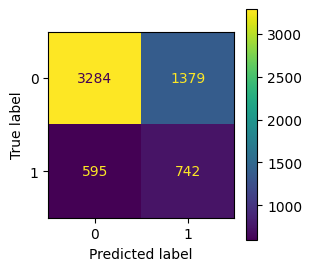

TPR: 55.5%
TNR: 70.43%
Accuracy: 67.1%
Balanced accuracy: 62.96%
K-fold: 0.727 accuracy with a standard deviation of 0.010


AttributeError: 'GridSearchCV' object has no attribute 'get_depth'

In [42]:
param_dist = {'criterion': ['gini', 'entropy'],
              'splitter': ['best'], #, 'random'
              'max_depth': [None, 35, 30]} 

mod_tree_grid = GridSearchCV(DecisionTreeClassifier(random_state = seed), param_grid = param_dist, scoring = scoring).fit(X_train, y_train)

print(mod_tree_grid.best_params_)
custom_metrics(mod_tree_grid, X_test, y_test)

print(f'\nDepht: {mod_tree_grid.get_depth()}', f'\nN. leaves: {mod_tree_grid.get_n_leaves()}')

### Support Vector Machine

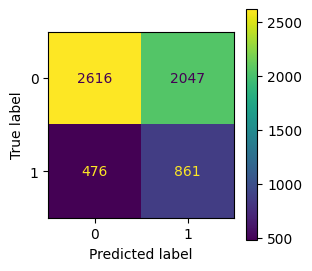

TPR: 64.4%
TNR: 56.1%
Accuracy: 57.95%
Balanced accuracy: 60.25%
K-fold: 0.777 accuracy with a standard deviation of 0.000


In [ ]:
mod_svc = SVC(random_state = seed).fit(X_train, y_train)
custom_metrics(mod_svc, X_test, y_test)

In [ ]:
param_dist = {'C': [1, 0.5, 2],
              'kernel': ['poly', 'linear', 'rbf']}

mod_svc_grid = GridSearchCV(SVC(random_state = seed), param_grid = param_dist, scoring = scoring).fit(X_train, y_train)

print(mod_svc_grid.best_params_)
custom_metrics(mod_svc_grid)

### Random Forest

Documentação: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

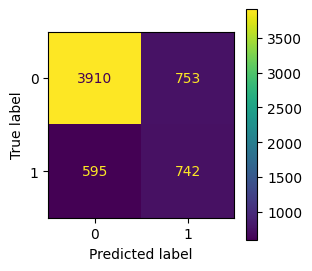

TPR: 55.5%
TNR: 83.85%
Accuracy: 77.53%
Balanced accuracy: 69.67%
K-fold: 0.812 accuracy with a standard deviation of 0.007


In [37]:
mod_forest = RandomForestClassifier(random_state = seed).fit(X_train, y_train)
custom_metrics(mod_forest, X_test, y_test)

{'criterion': 'entropy', 'n_estimators': 250}


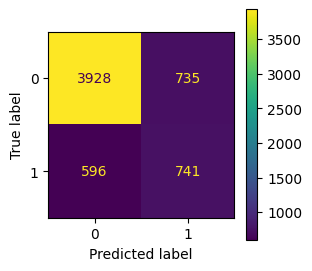

TPR: 55.42%
TNR: 84.24%
Accuracy: 77.82%
Balanced accuracy: 69.83%
K-fold: 0.813 accuracy with a standard deviation of 0.008


In [38]:
param_dist = {'n_estimators': [100, 250],
              'criterion': ['gini', 'entropy']}
#'max_features': ['sqrt', 'log2']

mod_forest_grid = GridSearchCV(RandomForestClassifier(random_state = seed), param_grid = param_dist, scoring = scoring).fit(X_train, y_train)

print(mod_forest_grid.best_params_)
custom_metrics(mod_forest_grid, X_test, y_test)